In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import time
from proj1_helpers import *
from Implementations import *
from Plot import *

# Plot saving
The plotting functions generate images that were saved using the plot_save argument, so if you want to recreate and overwrite the plots in the folder "figures/" when running the notebook, set plot_save to True. Warning: the old plots will be deleted (overwritten). This argument has now been set to False such that running the code will regenerate them in the notebook without overwriting them in the figure folder, enabling the control of reproducibility.

In [2]:
plot_save = False

# Loading data into feature matrix, class labels, and event ids:

Load train data:

In [3]:
#DATA_TRAIN_PATH = '../../data/train.csv/train.csv' # TODO: download train data and supply path here
if os.path.isdir('Datasets'):
    DATA_TRAIN_PATH = 'Datasets/train.csv'
elif os.path.isdir('data'):
    DATA_TRAIN_PATH = 'data/train.csv'
elif os.path.isdir('../Projet_1_data'):
    DATA_TRAIN_PATH = '../Projet_1_data/train.csv'
else:
    print("The Datasets folder cannot be found !")
print("Loading training data...")
t1 = time.time()
y_train, tX_train, ids_train = load_csv_data(DATA_TRAIN_PATH)
t2 = time.time()
print(f"Training data loaded ! ({round(t2-t1,2)} sec)")

Loading training data...
Training data loaded ! (14.38 sec)


Load test data (to do a common pre-processing with training data):

In [4]:
if os.path.isdir('Datasets'):
    DATA_TEST_PATH = 'Datasets/test.csv'
elif os.path.isdir('data'):
    DATA_TEST_PATH = 'data/test.csv'
elif os.path.isdir('../Projet_1_data'):
    DATA_TEST_PATH = '../Projet_1_data/test.csv'
else:
    print("The Datasets folder cannot be found !")
print("Loading testing data...")
t1 = time.time()
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
t2 = time.time()
print(f"Testing data loaded ! ({round(t2-t1,2)} sec)")

Loading testing data...
Testing data loaded ! (37.52 sec)


# Data visualization
### Raw dataset
Raw dataset visualization without preprocessing of the data:

Features visualization (raw dataset)


D:\Progs\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


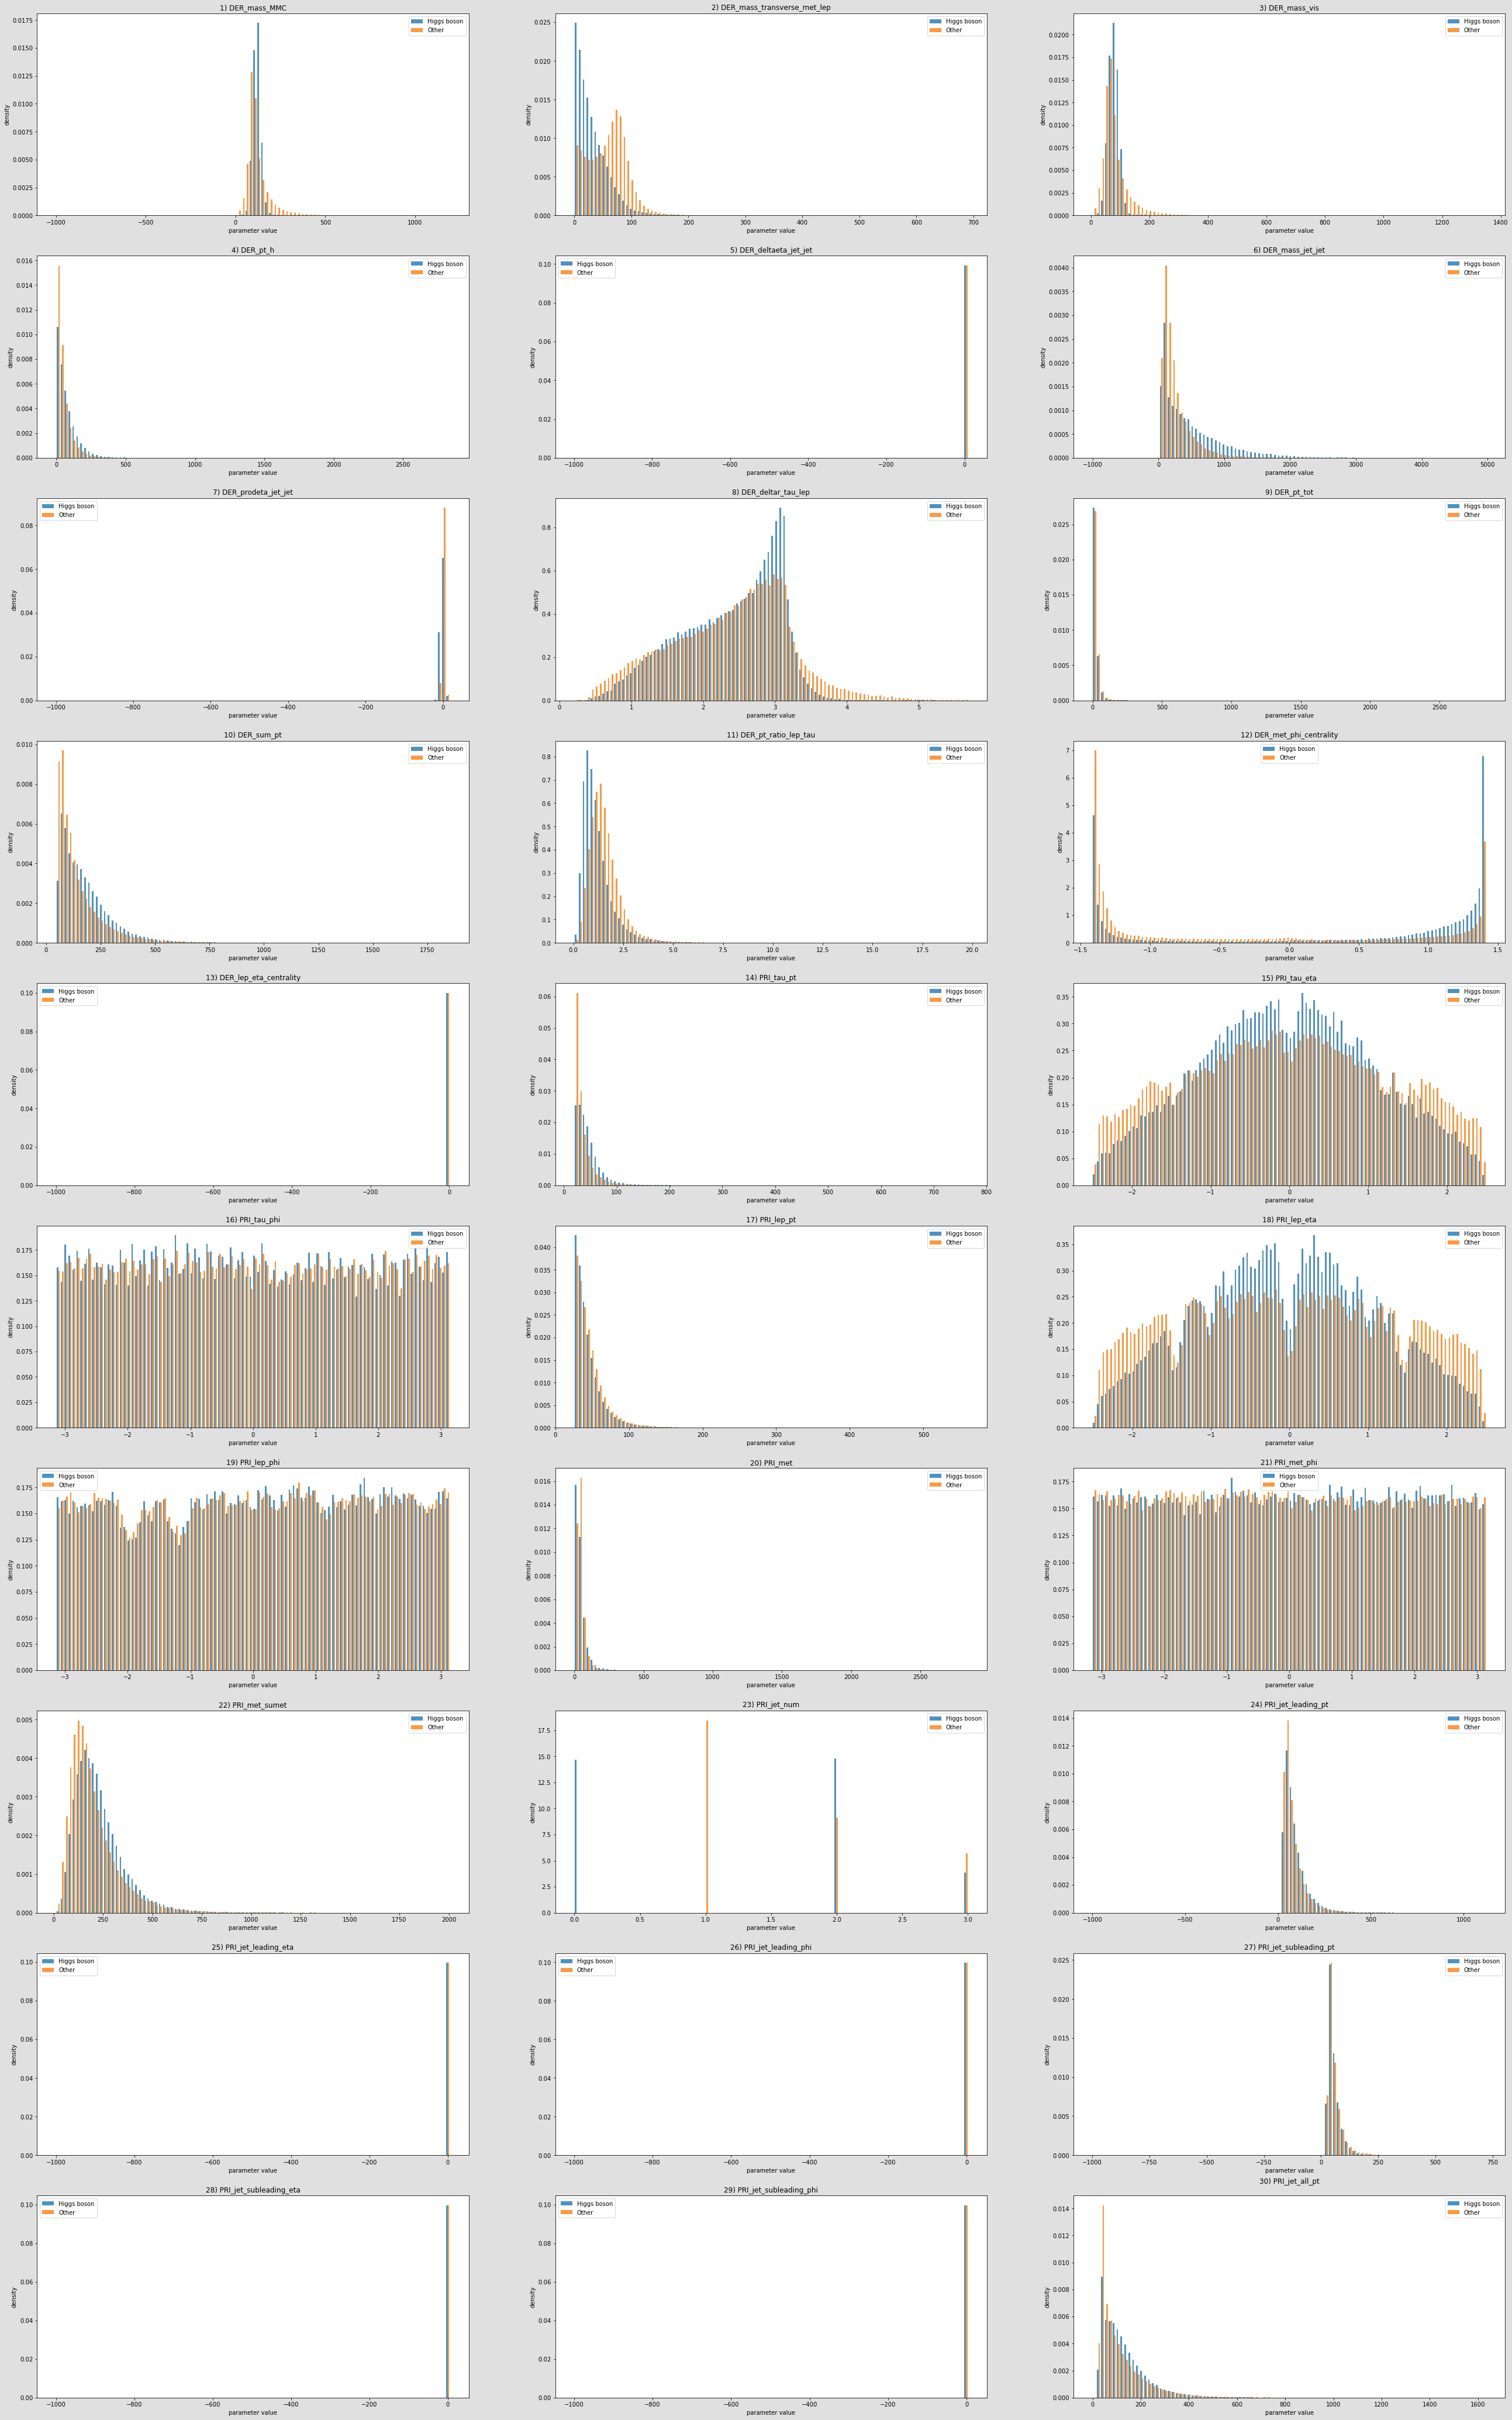

0

In [5]:
with open(DATA_TRAIN_PATH, mode='r') as f:
    param_names = np.array(f.readline().split(',')[2:])
print("Features visualization (raw dataset)")
plot_features_visualization(y_train, tX_train, names=param_names, save=plot_save)

### Preprocessed dataset
Preprocessed dataset visualization:

Features visualization (preprocessed dataset)


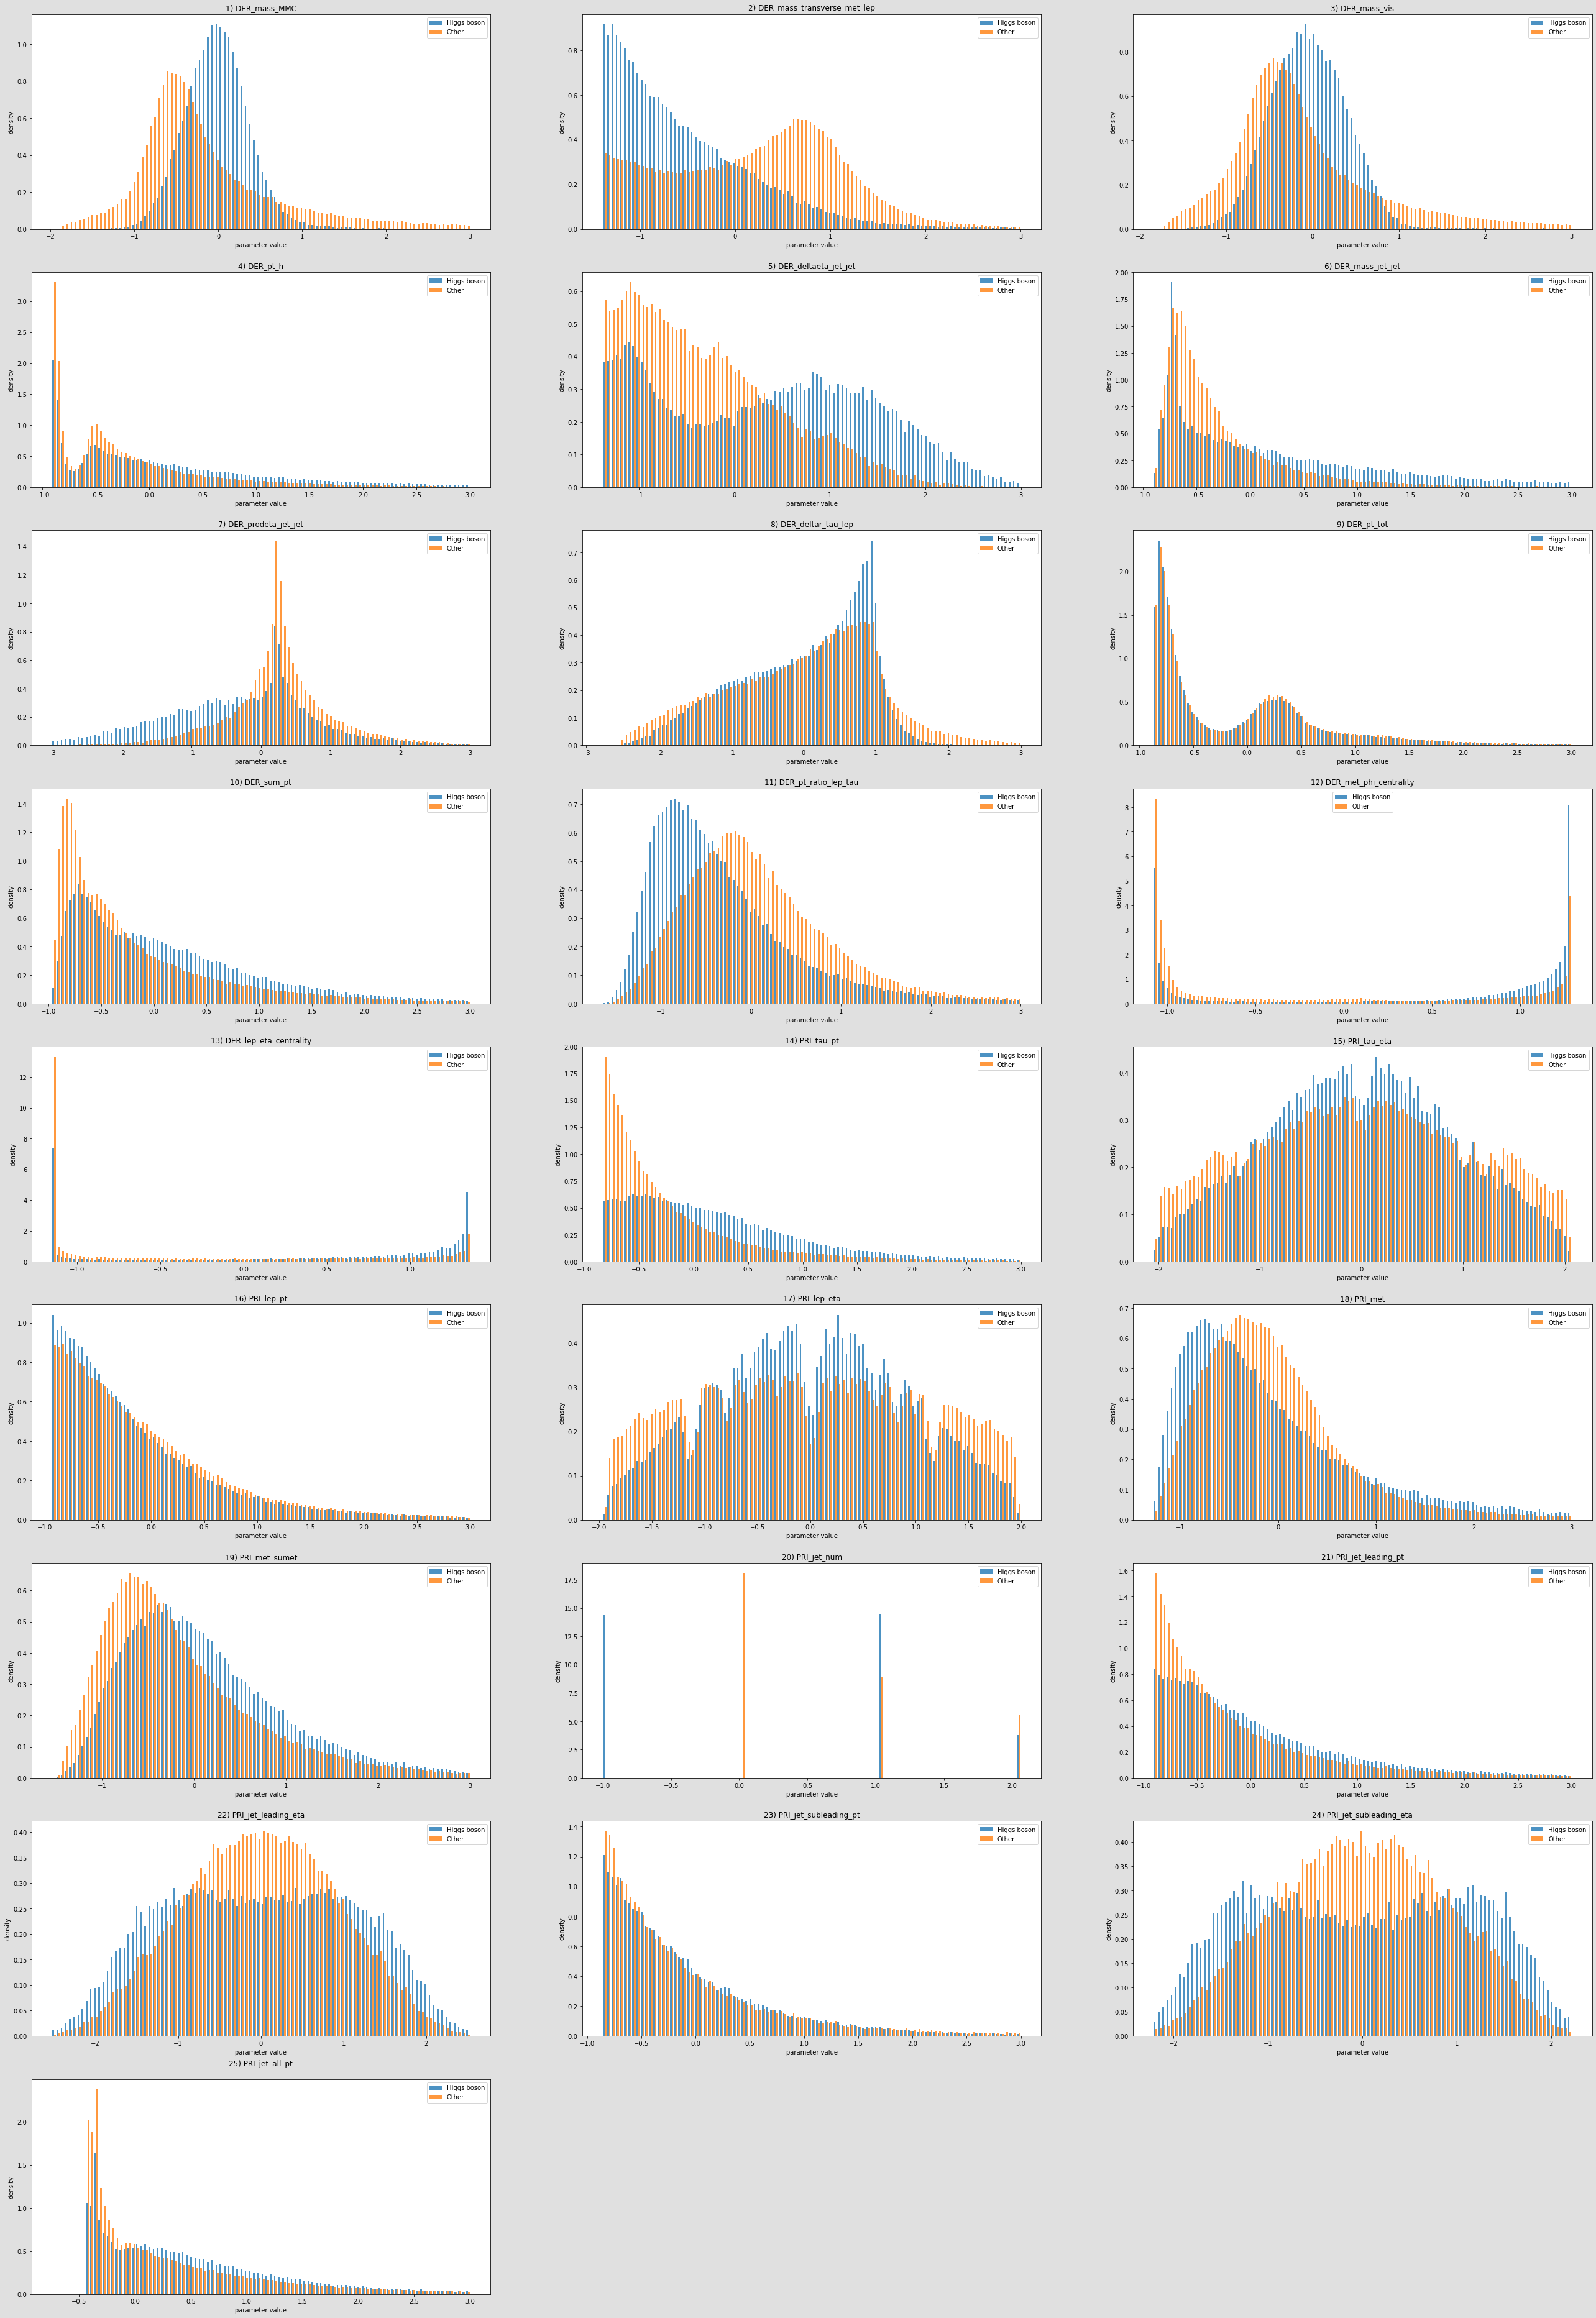

0

In [6]:
y_dv1, tX_dv1, _, _, _ = preprocess_data(y_train, tX_train, ids_train, tX_test, ids_test, param={'Build_poly':True,'Build_poly_degree':1})
param_names_dv = np.delete(param_names, [15,18,20,25,28]) # parameters removed in preprocess
print("Features visualization (preprocessed dataset)")
plot_features_visualization(y_dv1, tX_dv1[:,1:], names=param_names_dv, save=plot_save)

# TRAINING MODELS

### Setting global variables:

Including preprocessing of the data (train and test preprocessed together):

In [7]:
y_tr, tX_tr, ids_tr, tX_te, ids_te = preprocess_data(y_train, tX_train, ids_train, tX_test, ids_test, param={})
seed = 1
k_fold = 5
k_indices = build_k_indices(y_tr, k_fold, seed)

# Least squares

Parameters definition for optimization:

In [8]:
model = 'least_squares'
degrees = np.arange(1,16,1)

Parameters optimization:

In [9]:
losses_tr, losses_te, accs_tr, accs_te = params_optimization(y_tr, tX_tr, k_fold, model, degrees, params = None, seed = seed, feedback = True)

Optimizing degree 1/15, model: least_squares, arguments: None
Optimizing degree 2/15, model: least_squares, arguments: None
Optimizing degree 3/15, model: least_squares, arguments: None
Optimizing degree 4/15, model: least_squares, arguments: None
Optimizing degree 5/15, model: least_squares, arguments: None
Optimizing degree 6/15, model: least_squares, arguments: None
Optimizing degree 7/15, model: least_squares, arguments: None
Optimizing degree 8/15, model: least_squares, arguments: None
Optimizing degree 9/15, model: least_squares, arguments: None
Optimizing degree 10/15, model: least_squares, arguments: None
Optimizing degree 11/15, model: least_squares, arguments: None
Optimizing degree 12/15, model: least_squares, arguments: None
Optimizing degree 13/15, model: least_squares, arguments: None
Optimizing degree 14/15, model: least_squares, arguments: None
Optimizing degree 15/15, model: least_squares, arguments: None


Plot degree vs accuracy:

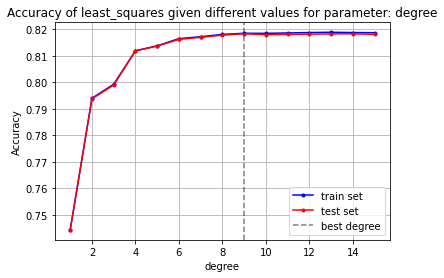

In [10]:
plot_param_vs_err(degrees, accs_tr, accs_te, model, 'Accuracy', save_img = plot_save, img_name = 'least_squares_accuracy')

Plot on MSE gave aberrant values, which illustrated that this loss is not appropriate nor always informative for categorization. We use labels mean accuracy for model selection and performance assessment.

Manually choose best parameters (we consider that 10 is safer than 9):

In [11]:
best_degree = 10

Compute performance on 5 splits with best parameters:

In [12]:
model = 'least_squares'
params = None

accs_te = []
for k in range(k_fold):
    _, _, _, acc_te = cross_validation(y_tr, tX_tr, k_indices, k, model, best_degree, params, feedback = True)
    accs_te.append(acc_te)

Starting cross-validation 1/5 for least_squares, extended feature of degree 10 and arguments : None
Starting cross-validation 2/5 for least_squares, extended feature of degree 10 and arguments : None
Starting cross-validation 3/5 for least_squares, extended feature of degree 10 and arguments : None
Starting cross-validation 4/5 for least_squares, extended feature of degree 10 and arguments : None
Starting cross-validation 5/5 for least_squares, extended feature of degree 10 and arguments : None


In [13]:
print('Mean accuracy of best least squares model: ', round(np.mean(accs_te),3))

Mean accuracy of best least squares model:  0.818


Store values for comparison with other models later:

In [14]:
np.save('best_models_perf/best_accs_' + model, accs_te)

# Least Squares GD 

Parameters definition for optimization. We use AdaGrad for learning rate:

In [15]:
model = 'least_squares_GD'
degrees = np.arange(1,7,1)
max_iters = 50
plot = False
params = {'max_iters' : max_iters, 'plot' : plot}

Parameters optimization:

In [16]:
losses_tr, losses_te, accs_tr, accs_te = params_optimization(y_tr, tX_tr, k_fold, model, degrees, params = params, seed = seed, feedback = True)

Optimizing degree 1/6, model: least_squares_GD, arguments: {'max_iters': 50, 'plot': False}
Optimizing degree 2/6, model: least_squares_GD, arguments: {'max_iters': 50, 'plot': False}
Optimizing degree 3/6, model: least_squares_GD, arguments: {'max_iters': 50, 'plot': False}
Optimizing degree 4/6, model: least_squares_GD, arguments: {'max_iters': 50, 'plot': False}
Optimizing degree 5/6, model: least_squares_GD, arguments: {'max_iters': 50, 'plot': False}
Optimizing degree 6/6, model: least_squares_GD, arguments: {'max_iters': 50, 'plot': False}


Plot degree vs accuracy:

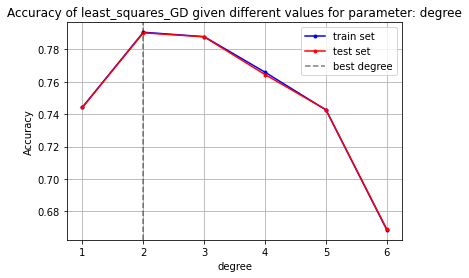

In [17]:
plot_param_vs_err(degrees, accs_tr, accs_te, model, 'Accuracy', save_img = plot_save, img_name = 'least_squares_GD_accuracy')

Manually choose best parameters:

In [18]:
best_degree = 2

Compute performance on 5 splits with best parameters:

Starting cross-validation 1/5 for least_squares_GD, extended feature of degree 2 and arguments : {'max_iters': 50, 'plot': True}
Starting cross-validation 2/5 for least_squares_GD, extended feature of degree 2 and arguments : {'max_iters': 50, 'plot': True}
Starting cross-validation 3/5 for least_squares_GD, extended feature of degree 2 and arguments : {'max_iters': 50, 'plot': True}
Starting cross-validation 4/5 for least_squares_GD, extended feature of degree 2 and arguments : {'max_iters': 50, 'plot': True}
Starting cross-validation 5/5 for least_squares_GD, extended feature of degree 2 and arguments : {'max_iters': 50, 'plot': True}


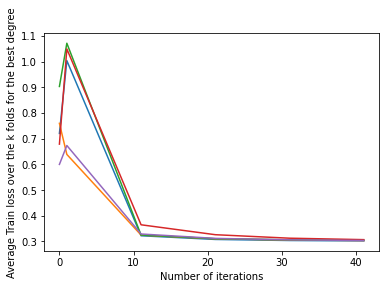

In [19]:
model = 'least_squares_GD'
max_iters = 50
plot = True
params = {'max_iters':max_iters, 'plot':plot}

accs_te = []
for k in range(k_fold):
    _, _, _, acc_te = cross_validation(y_tr, tX_tr, k_indices, k, model, best_degree, params, feedback = True)
    accs_te.append(acc_te)

In [20]:
print('Mean accuracy of best least squares gradient descent model: ', round(np.mean(accs_te),3))

Mean accuracy of best least squares gradient descent model:  0.791


Store values for comparison with other models later:

In [21]:
np.save('best_models_perf/best_accs_' + model, accs_te)

# Least squares SGD
### Batch size : 1

Parameters definition for optimization. We use AdaGrad for learning rate:

In [22]:
model = 'least_squares_SGD'
degrees = np.arange(1,7,1)
max_iters = 1000
batch_size = 1
plot = False
params = {'max_iters':max_iters, 'batch_size':batch_size, 'plot':plot}

In [23]:
losses_tr, losses_te, accs_tr, accs_te = params_optimization(y_tr, tX_tr, k_fold, model, degrees, params=params, seed = seed, feedback = True)

Optimizing degree 1/6, model: least_squares_SGD, arguments: {'max_iters': 1000, 'batch_size': 1, 'plot': False}
Optimizing degree 2/6, model: least_squares_SGD, arguments: {'max_iters': 1000, 'batch_size': 1, 'plot': False}
Optimizing degree 3/6, model: least_squares_SGD, arguments: {'max_iters': 1000, 'batch_size': 1, 'plot': False}
Optimizing degree 4/6, model: least_squares_SGD, arguments: {'max_iters': 1000, 'batch_size': 1, 'plot': False}
Optimizing degree 5/6, model: least_squares_SGD, arguments: {'max_iters': 1000, 'batch_size': 1, 'plot': False}
Optimizing degree 6/6, model: least_squares_SGD, arguments: {'max_iters': 1000, 'batch_size': 1, 'plot': False}


Plot degree vs accuracy:

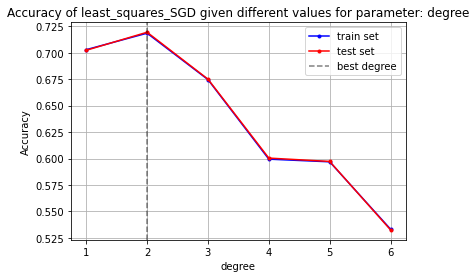

In [24]:
plot_param_vs_err(degrees, accs_tr, accs_te, model, 'Accuracy', save_img = plot_save, img_name = 'least_squares_SGD_batch_size_1_accuracy')

We see that the accuracy is very bad in comparison to the others. It is because a batch size (= 1) on 1000 iterations means we only look at 1000 datapoints (more iteration would take too much time).

Manually choose best parameters:

In [25]:
best_degree = 2

Compute performance on 5 splits with best parameters:

Starting cross-validation 1/5 for least_squares_SGD, extended feature of degree 2 and arguments : {'max_iters': 1000, 'batch_size': 1, 'plot': True}
Starting cross-validation 2/5 for least_squares_SGD, extended feature of degree 2 and arguments : {'max_iters': 1000, 'batch_size': 1, 'plot': True}
Starting cross-validation 3/5 for least_squares_SGD, extended feature of degree 2 and arguments : {'max_iters': 1000, 'batch_size': 1, 'plot': True}
Starting cross-validation 4/5 for least_squares_SGD, extended feature of degree 2 and arguments : {'max_iters': 1000, 'batch_size': 1, 'plot': True}
Starting cross-validation 5/5 for least_squares_SGD, extended feature of degree 2 and arguments : {'max_iters': 1000, 'batch_size': 1, 'plot': True}


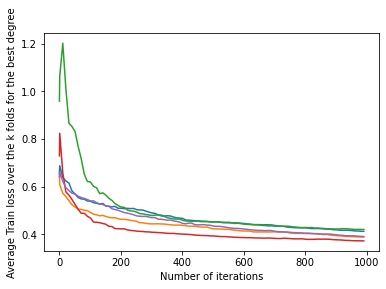

In [26]:
model = 'least_squares_SGD'
max_iters = 1000
batch_size = 1
params = {'max_iters':max_iters, 'batch_size':batch_size, 'plot':True}

accs_te = []
for k in range(k_fold):
    _, _, _, acc_te = cross_validation(y_tr, tX_tr, k_indices, k, model, best_degree, params, feedback = True)
    accs_te.append(acc_te)

In [27]:
print('Mean accuracy of best least squares stochastic gradient descent model (batch size = 1): ', round(np.mean(accs_te),3))

Mean accuracy of best least squares stochastic gradient descent model (batch size = 1):  0.703


We can see that a batch size of 1 does not give results that can be compared to other functional methods. We stored them but did not use them later on.

Store values:

In [28]:
np.save(f"best_models_perf/best_accs_{model}_{batch_size}", accs_te)

### Higher batch size value : 256
Parameters definition for optimization. Here we change the batch size to a higher value which solves the problem met before.

In [29]:
model = 'least_squares_SGD'
degrees = np.arange(1,7,1)
max_iters=1000
batch_size=256
plot = False
params={'max_iters':max_iters, 'batch_size':batch_size, 'plot':plot}

Parameters optimization:

In [30]:
losses_tr, losses_te, accs_tr, accs_te = params_optimization(y_tr, tX_tr, k_fold, model, degrees, params=params, seed = seed, feedback = True)

Optimizing degree 1/6, model: least_squares_SGD, arguments: {'max_iters': 1000, 'batch_size': 256, 'plot': False}
Optimizing degree 2/6, model: least_squares_SGD, arguments: {'max_iters': 1000, 'batch_size': 256, 'plot': False}
Optimizing degree 3/6, model: least_squares_SGD, arguments: {'max_iters': 1000, 'batch_size': 256, 'plot': False}
Optimizing degree 4/6, model: least_squares_SGD, arguments: {'max_iters': 1000, 'batch_size': 256, 'plot': False}
Optimizing degree 5/6, model: least_squares_SGD, arguments: {'max_iters': 1000, 'batch_size': 256, 'plot': False}
Optimizing degree 6/6, model: least_squares_SGD, arguments: {'max_iters': 1000, 'batch_size': 256, 'plot': False}


Plot degree vs accuracy:

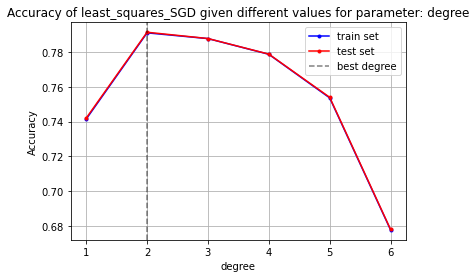

In [31]:
plot_param_vs_err(degrees, accs_tr, accs_te, model, 'Accuracy', save_img = plot_save, img_name = 'least_squares_SGD_batch_size_250_accuracy')

Manually choose best parameters:

In [32]:
best_degree = 2

Compute performance on k splits with best parameters:

Starting cross-validation 1/5 for least_squares_SGD, extended feature of degree 2 and arguments : {'max_iters': 1000, 'batch_size': 256, 'plot': True}
Starting cross-validation 2/5 for least_squares_SGD, extended feature of degree 2 and arguments : {'max_iters': 1000, 'batch_size': 256, 'plot': True}
Starting cross-validation 3/5 for least_squares_SGD, extended feature of degree 2 and arguments : {'max_iters': 1000, 'batch_size': 256, 'plot': True}
Starting cross-validation 4/5 for least_squares_SGD, extended feature of degree 2 and arguments : {'max_iters': 1000, 'batch_size': 256, 'plot': True}
Starting cross-validation 5/5 for least_squares_SGD, extended feature of degree 2 and arguments : {'max_iters': 1000, 'batch_size': 256, 'plot': True}


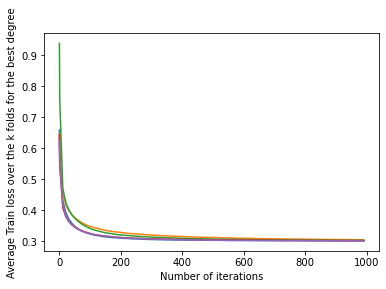

In [33]:
model = 'least_squares_SGD'
max_iters=1000
batch_size=256
plot = True
params = {'max_iters':max_iters, 'batch_size':batch_size, 'plot':plot}

accs_te = []
for k in range(k_fold):
    _, _, _, acc_te = cross_validation(y_tr, tX_tr, k_indices, k, model, best_degree, params, feedback = True)
    accs_te.append(acc_te)

In [34]:
print('Mean accuracy of best least squares stochastic gradient descent model (batch size = 256): ', round(np.mean(accs_te),3))

Mean accuracy of best least squares stochastic gradient descent model (batch size = 256):  0.791


With this batch size, we have coherent results.

Store values for comparison with other models later:

In [35]:
np.save(f"best_models_perf/best_accs_{model}_{batch_size}", accs_te)

# Ridge regression

Parameters definition for optimization

In [36]:
model = 'ridge_regression'
degrees = np.arange(1,15,1)
lambdas = np.logspace(-6,0,7)

Parameters optimization:

In [37]:
losses_tr, losses_te, accs_tr, accs_te = params_optimization(y_tr, tX_tr, k_fold, model, degrees, lambdas, params = None, seed = seed, feedback = True)

Optimizing degree 1/14, model: ridge_regression, arguments: {'lambda': 1e-06}
Optimizing degree 1/14, model: ridge_regression, arguments: {'lambda': 1e-05}
Optimizing degree 1/14, model: ridge_regression, arguments: {'lambda': 0.0001}
Optimizing degree 1/14, model: ridge_regression, arguments: {'lambda': 0.001}
Optimizing degree 1/14, model: ridge_regression, arguments: {'lambda': 0.01}
Optimizing degree 1/14, model: ridge_regression, arguments: {'lambda': 0.1}
Optimizing degree 1/14, model: ridge_regression, arguments: {'lambda': 1.0}
Optimizing degree 2/14, model: ridge_regression, arguments: {'lambda': 1e-06}
Optimizing degree 2/14, model: ridge_regression, arguments: {'lambda': 1e-05}
Optimizing degree 2/14, model: ridge_regression, arguments: {'lambda': 0.0001}
Optimizing degree 2/14, model: ridge_regression, arguments: {'lambda': 0.001}
Optimizing degree 2/14, model: ridge_regression, arguments: {'lambda': 0.01}
Optimizing degree 2/14, model: ridge_regression, arguments: {'lambda

Here we optimized over 2 parameters, so we use heatmap to visualize best combination

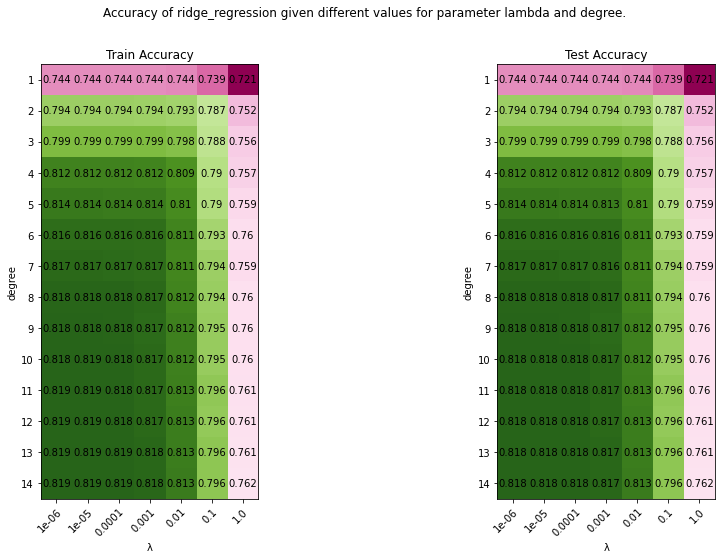

In [38]:
plot_heatmap(accs_tr, accs_te, degrees, lambdas, model, measure_type = 'Accuracy', save_img = plot_save, img_name = 'Heatmap_accuracy_ridge_regression')

Manually choose best parameters:

In [39]:
best_lambda = 1e-6
best_degree = 10

Compute performance on 5 splits with best parameters:

In [40]:
model = 'ridge_regression'
params = {'lambda' : best_lambda}

accs_te = []
for k in range(k_fold):
    _, _, _, acc_te = cross_validation(y_tr, tX_tr, k_indices, k, model, best_degree, params, feedback = True)
    accs_te.append(acc_te)

Starting cross-validation 1/5 for ridge_regression, extended feature of degree 10 and arguments : {'lambda': 1e-06}
Starting cross-validation 2/5 for ridge_regression, extended feature of degree 10 and arguments : {'lambda': 1e-06}
Starting cross-validation 3/5 for ridge_regression, extended feature of degree 10 and arguments : {'lambda': 1e-06}
Starting cross-validation 4/5 for ridge_regression, extended feature of degree 10 and arguments : {'lambda': 1e-06}
Starting cross-validation 5/5 for ridge_regression, extended feature of degree 10 and arguments : {'lambda': 1e-06}


In [41]:
print('Mean accuracy of best ridge regression model: ', round(np.mean(accs_te),3))

Mean accuracy of best ridge regression model:  0.818


Store values for comparison with other models later:

In [42]:
np.save('best_models_perf/best_accs_' + model, accs_te)

# Logistic regression

Parameters definition for optimization. We use AdaGrad for learning rate adaptation and Euler's method for weights update to reach better results.

In [43]:
model = 'logistic_regression'
degrees = np.arange(1,10,1)
max_iters = 1000
gamma = 0.1
batch_size = 256
AdaGrad = True
Newton_method = False
params = {'max_iters' : max_iters, 'gamma' : gamma}
params_logistic = {'Batch_size' : batch_size, 'AdaGrad' : AdaGrad, 'Newton_method' : Newton_method}

Parameters optimization:

In [44]:
losses_tr, losses_te, accs_tr, accs_te = params_optimization(y_tr, tX_tr, k_fold, model, degrees, params = params, params_logistic = params_logistic, seed = seed, feedback = True)

Optimizing degree 1/9, model: logistic_regression, arguments: {'max_iters': 1000, 'gamma': 0.1}
Optimizing degree 2/9, model: logistic_regression, arguments: {'max_iters': 1000, 'gamma': 0.1}
Optimizing degree 3/9, model: logistic_regression, arguments: {'max_iters': 1000, 'gamma': 0.1}
Optimizing degree 4/9, model: logistic_regression, arguments: {'max_iters': 1000, 'gamma': 0.1}
Optimizing degree 5/9, model: logistic_regression, arguments: {'max_iters': 1000, 'gamma': 0.1}
Optimizing degree 6/9, model: logistic_regression, arguments: {'max_iters': 1000, 'gamma': 0.1}
Optimizing degree 7/9, model: logistic_regression, arguments: {'max_iters': 1000, 'gamma': 0.1}
Optimizing degree 8/9, model: logistic_regression, arguments: {'max_iters': 1000, 'gamma': 0.1}
Optimizing degree 9/9, model: logistic_regression, arguments: {'max_iters': 1000, 'gamma': 0.1}


Plot degree vs accuracy:

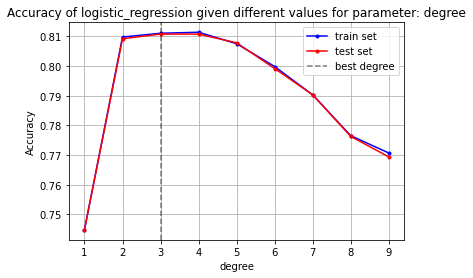

In [45]:
plot_param_vs_err(degrees, accs_tr, accs_te, model, 'Accuracy', save_img = plot_save, img_name = 'logistic_regression_accuracy')

Manually choose best parameters. We chose 4 because it seems that there is nearly no difference between 2 and 4 and the right-tail of the plot decreases slower than the left-tail:

In [46]:
best_degree = 4

Compute performance on 5 splits with best parameters:

In [47]:
model = 'logistic_regression'
max_iters = 1000
gamma = 0.1
batch_size = 256
AdaGrad = True
Newton_method = False
params = {'max_iters' : max_iters, 'gamma' : gamma}
params_logistic = {'Batch_size' : batch_size, 'AdaGrad' : AdaGrad, 'Newton_method' : Newton_method}

accs_te = []
for k in range(k_fold):
    _, _, _, acc_te = cross_validation(y_tr, tX_tr, k_indices, k, model, best_degree, params, params_logistic = params_logistic, feedback = True)
    accs_te.append(acc_te)

Starting cross-validation 1/5 for logistic_regression, extended feature of degree 4 and arguments : {'max_iters': 1000, 'gamma': 0.1}
Starting cross-validation 2/5 for logistic_regression, extended feature of degree 4 and arguments : {'max_iters': 1000, 'gamma': 0.1}
Starting cross-validation 3/5 for logistic_regression, extended feature of degree 4 and arguments : {'max_iters': 1000, 'gamma': 0.1}
Starting cross-validation 4/5 for logistic_regression, extended feature of degree 4 and arguments : {'max_iters': 1000, 'gamma': 0.1}
Starting cross-validation 5/5 for logistic_regression, extended feature of degree 4 and arguments : {'max_iters': 1000, 'gamma': 0.1}


In [48]:
print('Mean accuracy of best logistic regression model: ', round(np.mean(accs_te),3))

Mean accuracy of best logistic regression model:  0.811


Store values for comparison with other models later:

In [49]:
np.save(f'best_models_perf/best_accs_{model}_{batch_size}', accs_te)

# Regularized Logistic regression

Preprocessing and parameters definition for optimization. Again, we use AdaGrad instead of Newton.

In [52]:
model = 'reg_logistic_regression'
degrees = np.arange(1,7,1)
lambdas = np.logspace(-6,0,7)
max_iters = 1000
gamma = 0.1
batch_size = 256
AdaGrad = True
Newton_method = False
params = {'max_iters' : max_iters, 'gamma' : gamma}
params_logistic = {'Batch_size' : batch_size, 'AdaGrad' : AdaGrad, 'Newton_method' : Newton_method}

Parameters optimization:

In [53]:
losses_tr, losses_te, accs_tr, accs_te = params_optimization(y_tr, tX_tr, k_fold, model, degrees, lambdas, params = params, params_logistic = params_logistic, seed = seed, feedback = True)

Optimizing degree 1/6, model: reg_logistic_regression, arguments: {'max_iters': 1000, 'gamma': 0.1, 'lambda': 1e-06}
Optimizing degree 1/6, model: reg_logistic_regression, arguments: {'max_iters': 1000, 'gamma': 0.1, 'lambda': 1e-05}
Optimizing degree 1/6, model: reg_logistic_regression, arguments: {'max_iters': 1000, 'gamma': 0.1, 'lambda': 0.0001}
Optimizing degree 1/6, model: reg_logistic_regression, arguments: {'max_iters': 1000, 'gamma': 0.1, 'lambda': 0.001}
Optimizing degree 1/6, model: reg_logistic_regression, arguments: {'max_iters': 1000, 'gamma': 0.1, 'lambda': 0.01}
Optimizing degree 1/6, model: reg_logistic_regression, arguments: {'max_iters': 1000, 'gamma': 0.1, 'lambda': 0.1}
Optimizing degree 1/6, model: reg_logistic_regression, arguments: {'max_iters': 1000, 'gamma': 0.1, 'lambda': 1.0}
Optimizing degree 2/6, model: reg_logistic_regression, arguments: {'max_iters': 1000, 'gamma': 0.1, 'lambda': 1e-06}
Optimizing degree 2/6, model: reg_logistic_regression, arguments: {'

Here we optimized over 2 parameters, so we use heatmap to visualize best combination:

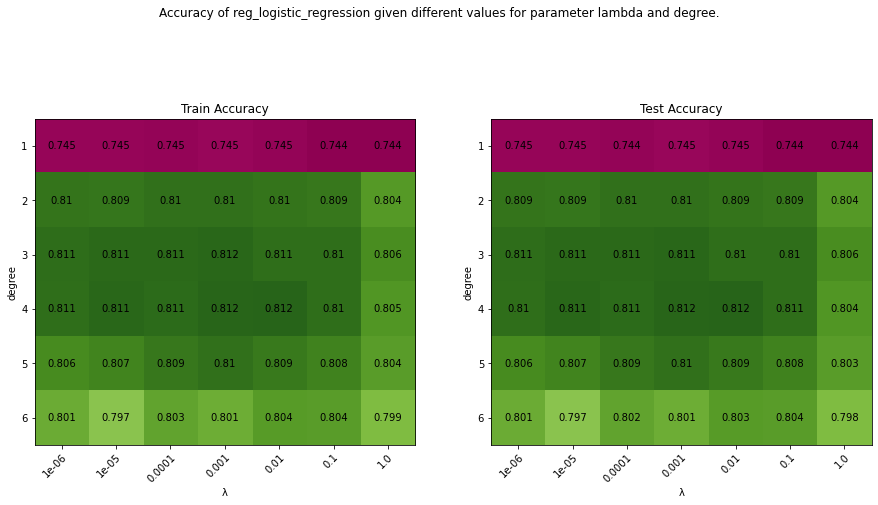

In [54]:
plot_heatmap(accs_tr, accs_te, degrees, lambdas, model, measure_type = 'Accuracy', save_img = plot_save, img_name = 'Heatmap_accuracy_reg_log_regression')

Manually choose best parameters:

In [55]:
best_degree = 4
best_lambda = 1e-3

Compute performance on 5 splits with best parameters:

In [56]:
model = 'reg_logistic_regression'
max_iters = 1000
gamma = 0.1
batch_size = 256
AdaGrad = True
Newton_method = False
params = {'max_iters' : max_iters, 'gamma' : gamma, 'lambda' : best_lambda}
params_logistic = {'Batch_size' : batch_size, 'AdaGrad' : AdaGrad, 'Newton_method' : Newton_method}

accs_te = []
for k in range(k_fold):
    _, _, _, acc_te = cross_validation(y_tr, tX_tr, k_indices, k, model, best_degree, params, params_logistic = params_logistic, feedback = True)
    accs_te.append(acc_te)

Starting cross-validation 1/5 for reg_logistic_regression, extended feature of degree 4 and arguments : {'max_iters': 1000, 'gamma': 0.1, 'lambda': 0.001}
Starting cross-validation 2/5 for reg_logistic_regression, extended feature of degree 4 and arguments : {'max_iters': 1000, 'gamma': 0.1, 'lambda': 0.001}
Starting cross-validation 3/5 for reg_logistic_regression, extended feature of degree 4 and arguments : {'max_iters': 1000, 'gamma': 0.1, 'lambda': 0.001}
Starting cross-validation 4/5 for reg_logistic_regression, extended feature of degree 4 and arguments : {'max_iters': 1000, 'gamma': 0.1, 'lambda': 0.001}
Starting cross-validation 5/5 for reg_logistic_regression, extended feature of degree 4 and arguments : {'max_iters': 1000, 'gamma': 0.1, 'lambda': 0.001}


In [57]:
print('Mean accuracy of best regularized logistic regression model: ', round(np.mean(accs_te),3))

Mean accuracy of best regularized logistic regression model:  0.811


Store values for comparison with other models later:

In [58]:
np.save(f'best_models_perf/best_accs_{model}_{batch_size}', accs_te)

# Boxplots and variance of best models

We reload results previously stored for each optimized model and plot them using boxplots:

In [59]:
in_ = 'best_models_perf/best_accs_'
accs_ls_GD = np.load(f'{in_}least_squares_GD.npy')
#accs_ls_SGD_1 = np.load(f'{in_}least_squares_SGD_1.npy')
accs_ls_SGD_256 = np.load(f'{in_}least_squares_SGD_256.npy')
accs_ls = np.load(f'{in_}least_squares.npy')
accs_ridge = np.load(f'{in_}ridge_regression.npy')
accs_log = np.load(f'{in_}logistic_regression_256.npy')
accs_reg_log = np.load(f'{in_}reg_logistic_regression_256.npy')

In [65]:
accuracies = np.array([accs_ls_GD, accs_ls_SGD_256, accs_ls, accs_ridge, accs_log, accs_reg_log])
stds = np.std(accuracies, axis = 1)
means = np.mean(accuracies, axis = 1)
model_names = np.array(['Least sq. GD', 'Least sq. SGD_256', 'Least sq.','Ridge','Log_256','Reg log_256'])

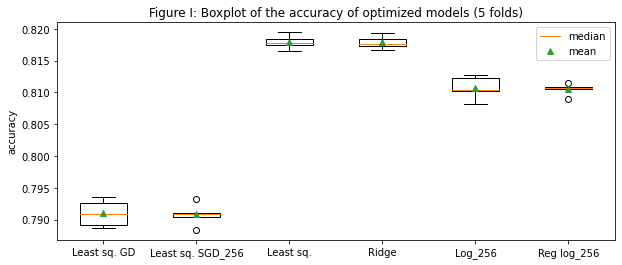

Least sq. GD: mean = 0.791, std = 0.0019
Least sq. SGD_256: mean = 0.7908, std = 0.0016
Least sq.: mean = 0.8179, std = 0.001
Ridge: mean = 0.8179, std = 0.0009
Log_256: mean = 0.8107, std = 0.0016
Reg log_256: mean = 0.8105, std = 0.0009


In [67]:
plot_boxplots(accuracies, model_names, err_type = 'accuracy', save_img = plot_save, img_name = 'Boxplots of best models')
for i, model in enumerate(model_names):
    print(f'{model}: mean = {round(means[i],4)}, std = {round(stds[i],4)}')

# Data visualization with predictions: <br>true/false positive/negative

Features visualization (preprocessed dataset with predictions)


D:\Progs\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


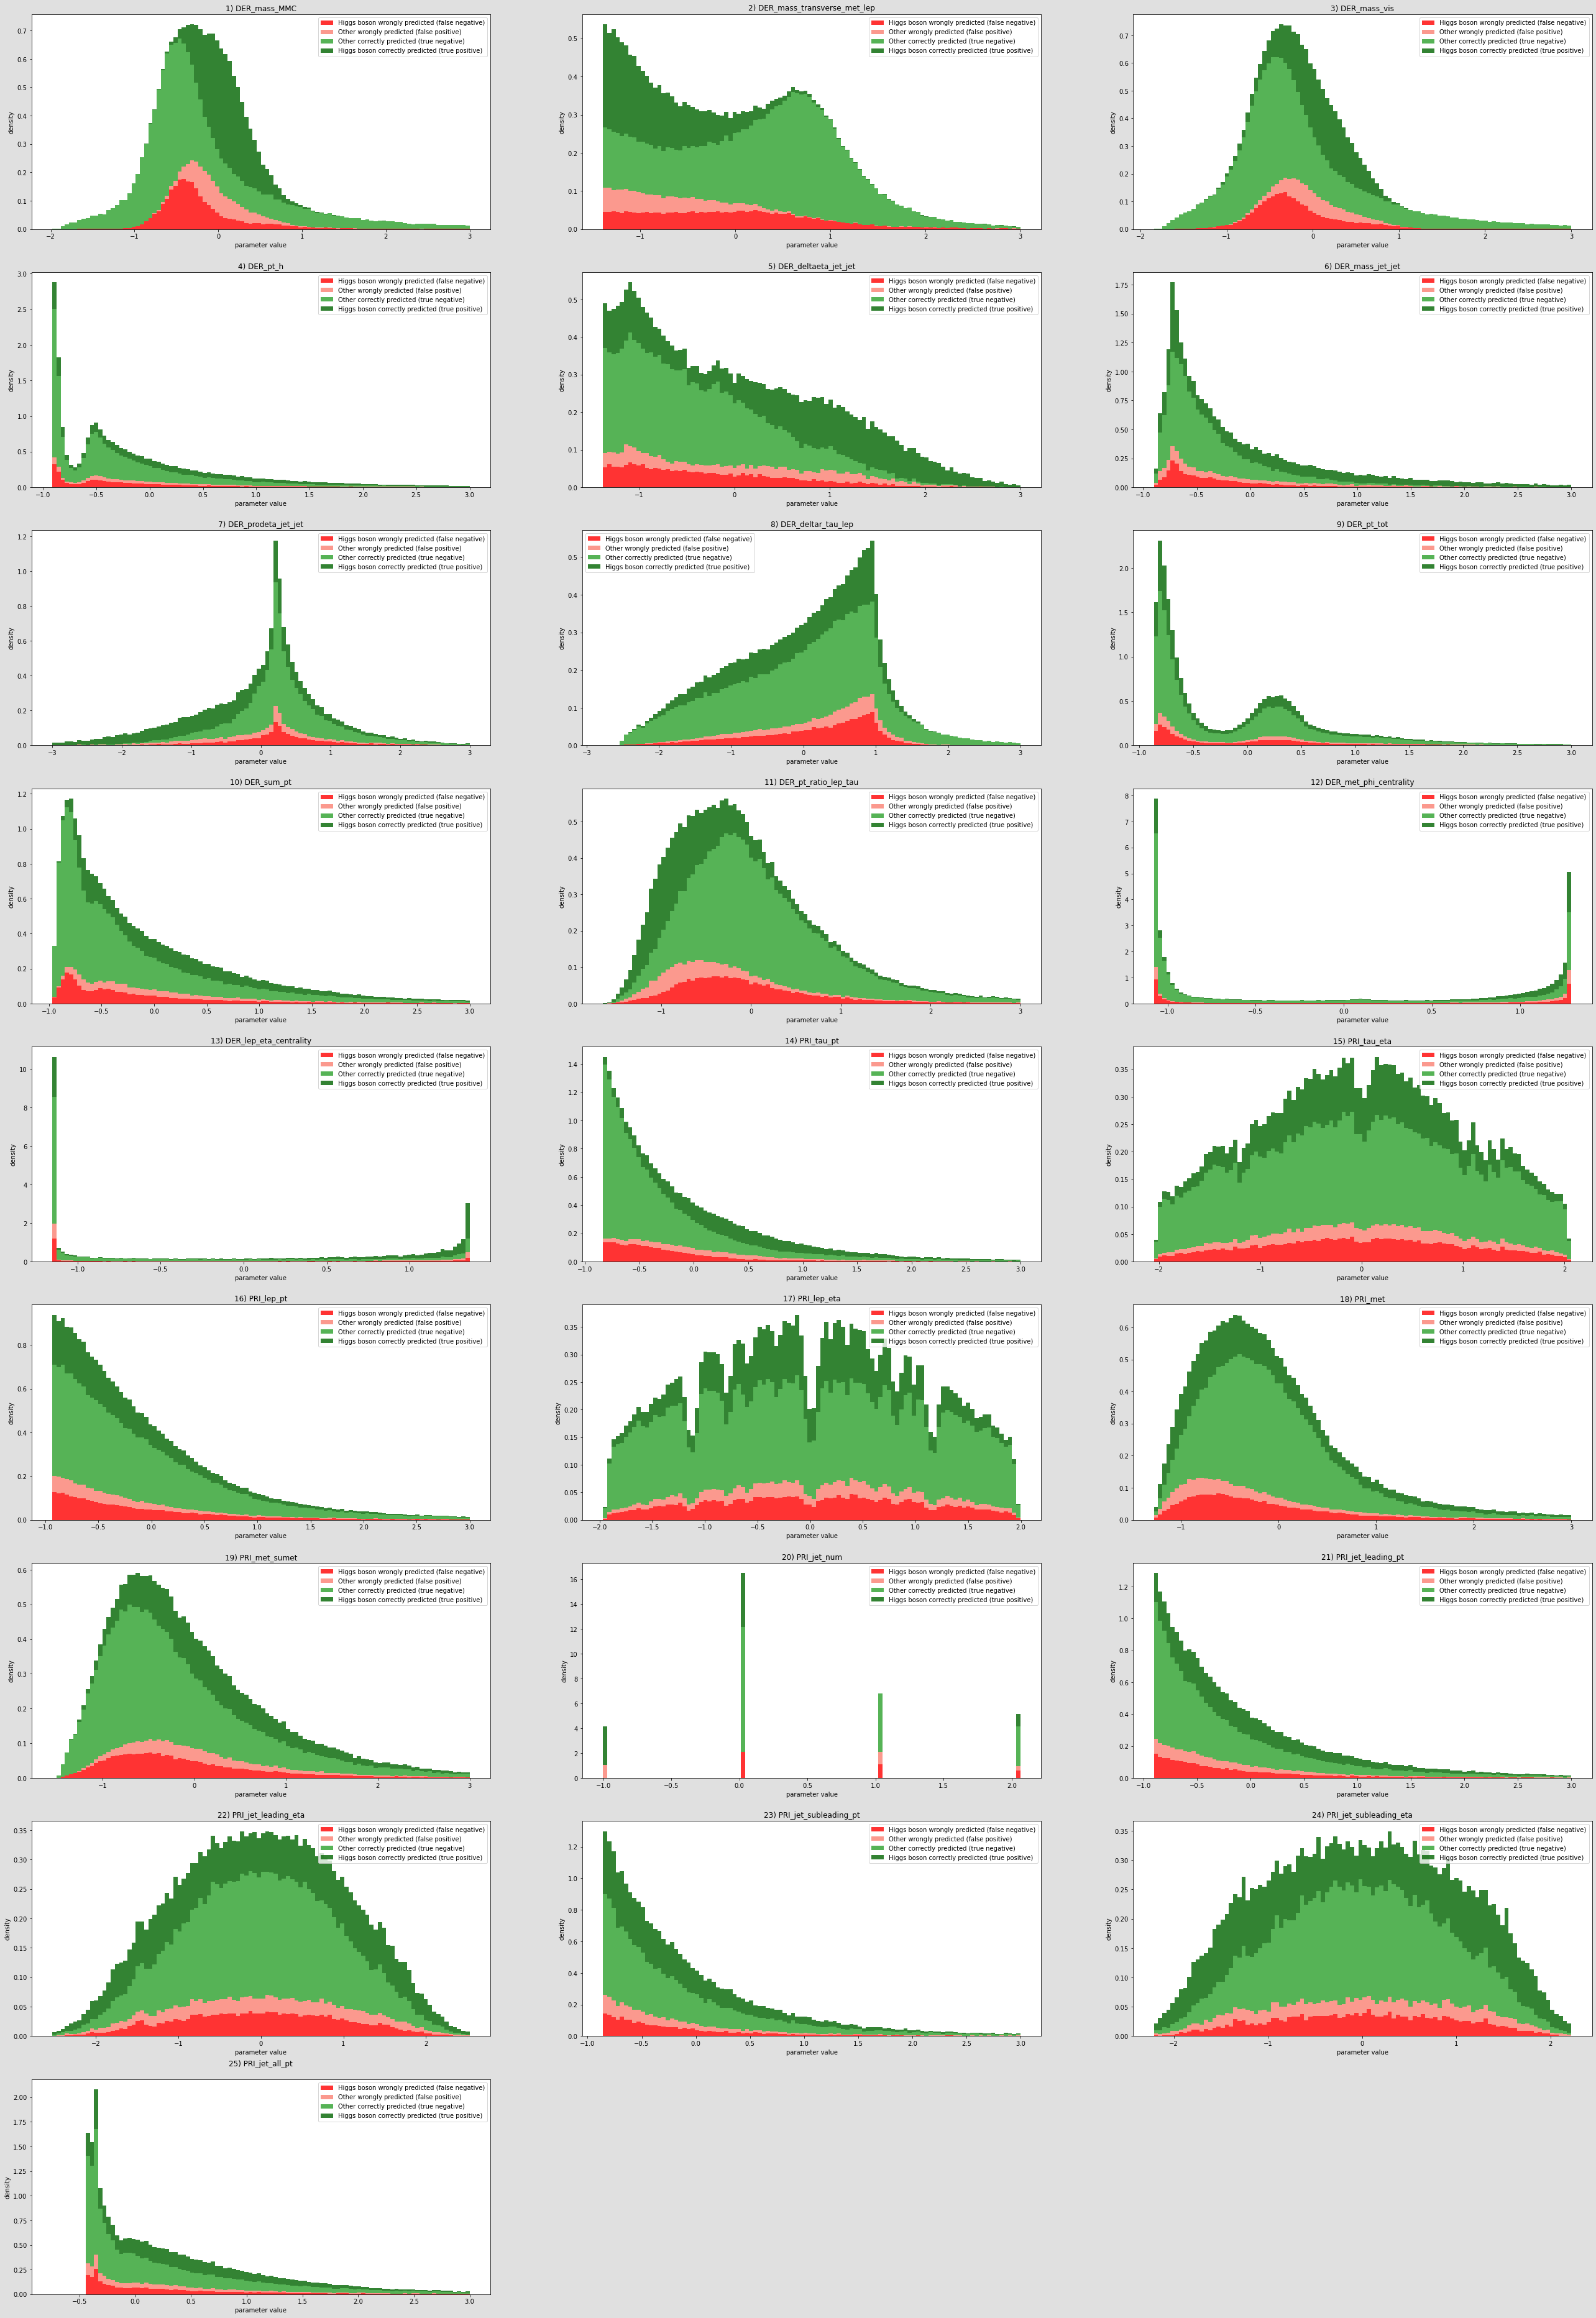

0

In [62]:
y_dv2, tX_dv2, _, _, _ = preprocess_data(y_train, tX_train, ids_train, tX_test, ids_test, param={'Build_poly':True, 'Build_poly_degree': 10})
w_dv, _ = ridge_regression(y_dv2, tX_dv2, 0.0001)
y_pred_dv = predict_labels(w_dv.reshape(-1,1), tX_dv2)

print("Features visualization (preprocessed dataset with predictions)")
plot_features_visualization(y_dv1, tX_dv1[:,1:], y_pred_dv, names=param_names_dv, save=plot_save)

# Generate predictions and save ouput in csv format for submission:

Ridge trial submission
<br> Model creation and test_data preprocessing
<br> The two next cells save the predictions for a specific model (one optimized ridge).
<br> These cells are only here to save the predictions "for fun" but it is not our best model and our best predictions.

In [61]:
y_tr, tX_tr, ids_tr, tX_te, ids_te = preprocess_data(y_train, tX_train, ids_train, tX_test, ids_test, param={'Build_poly': True, 'Build_poly_degree' : 10})
best_lambda = 1e-6
weights, loss = ridge_regression(y_tr, tX_tr, best_lambda)

In [62]:
OUTPUT_PATH = 'Results/ridge_poly10_1e-6.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_te)
create_csv_submission(ids_te, y_pred, OUTPUT_PATH)